In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

This tutorial shows how to train an image classification model and get feature attributions on your trained model.

### Dataset

[ImageNet](http://www.image-net.org/) is an image database. The images in the database are organized into a hierarchy, with each node of the hierarchy depicted by hundreds and thousands of images.

### Objective

In this notebook, you will learn how to use AI Explanations with an image model you trained. The purpose of this tutorial is to demonstrate how to explain your model locally using the Explainable AI SDK, without having to deploy to AI Platform. The steps performed include: 

* Train an ImageNet model.
* Get explanations locally in the AI Platform Notebooks environment
* \[Optional\] Deploy the model to AI Platform.

### Costs 

This tutorial uses billable components of Google Cloud Platform (GCP):

* AI Platform Prediction, if you decide to deploy the model

Learn about [Cloud AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin
This notebook is intended to run on [AI Platform Notebooks](https://cloud.google.com/ai-platform-notebooks) since it contains necessary dependencies including (but not limited to) [Explainable AI SDK](https://github.com/GoogleCloudPlatform/explainable_ai_sdk).

### GPU run-time

**Running this notebook in a GPU runtime will make you run training cells much faster.**

### Import libraries and define constants

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import explainable_ai_sdk
from explainable_ai_sdk.model import configs
import tensorflow_hub as hub
from base64 import b64encode

from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
from PIL import Image

## Build the Model

Build an ImageNet model using a pretrained model from TF Hub as a layer.

In [2]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),                     
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/classification/4"),
    tf.keras.layers.Softmax()
])

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              1692489   
_________________________________________________________________
softmax (Softmax)            (None, 1001)              0         
Total params: 1,692,489
Trainable params: 0
Non-trainable params: 1,692,489
_________________________________________________________________


### Save the Model

Before saving the model, add some preprocessing to the model so that you can just call it with an image without having to resize and decode every time. Here, the model is saved with 3 signatures:
1. Serving signature that takes image as bytes and outputs probabilities
2. Model signature that receives image as (224, 224)-shaped float array and outputs probabilities. Provide this signature to the metadata builder to pick up the correct inputs for the model.
3. Preprocessing signature that takes as image bytes and outputs preprocessed image as an array. 

In [ ]:
model_path = 'imagenet_model'

def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(224, 224))
    return resized

@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(_preprocess, bytes_inputs, dtype=tf.float32, back_prop=False)
    return {"numpy_inputs": decoded_images}  # Make note of the key.

m_call = tf.function(model.call).get_concrete_function(
    [tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32, name="numpy_inputs")])

@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob

tf.saved_model.save(model, model_path, signatures={
    'serving_default': serving_fn,
    'xai_preprocess': preprocess_fn, # Required for XAI
    'xai_model': m_call # Required for XAI since the default fn takes bytes.
    })

## Get Explanations
In this section, you will explain the output of the model for input images. The explanation workflow includes the following steps:

* Create an explanation metadata file to specify your model's inputs and outputs.
* Reload the model through [Explainable AI SDK](https://github.com/GoogleCloudPlatform/explainable_ai_sdk) with explanation parameters.
* Call `explain` function with images to get feature attributions.
* Use `visualize_attributions` function to visualize the model explanations.

### Create Explanation Metadata
Metadata specifies which inputs you want to explain in the model and other parameters such as baselines. Use `explainable_ai_sdk` helpers to create and save the metadata in the model folder.

In [5]:
# Provide the model path and signature to explain.
md_builder = SavedModelMetadataBuilder(model_path, signature_name='xai_model')

# Call md_builder.get_metadata() to see inferred inputs and outputs.
md_builder.set_image_metadata('numpy_inputs')  # Set 'numpy_inputs' input as image input.
md_builder.save_metadata(model_path)  # Save the metadata in the model path.

### Reload the Model through Explainable AI SDK
While reloading the model, you can specify which explanation technique to use. For image models, XRAI technique is recommended. The only parameter XRAI configuration class takes is `step_count`, which specifies the number of intervals for integral approximation.

In [6]:
lm = explainable_ai_sdk.load_model_from_local_path(
    model_path,  # Model path containing explanation metadata JSON.
    explainable_ai_sdk.XraiConfig()  # XRAI config with default step_count=50.
)

### Explain an Input
Download an image from the web and explain it.

In [7]:
# Download a jellyfish image.
! wget 'https://upload.wikimedia.org/wikipedia/commons/4/44/Jelly_cc11.jpg' -O 'jellyfish.jpg'

--2020-09-09 20:54:11--  https://upload.wikimedia.org/wikipedia/commons/4/44/Jelly_cc11.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78824 (77K) [image/jpeg]
Saving to: ‘jellyfish.jpg’

jellyfish.jpg       100%[===================>]  76.98K  --.-KB/s    in 0.09s   

2020-09-09 20:54:12 (875 KB/s) - ‘jellyfish.jpg’ saved [78824/78824]



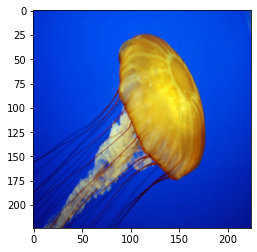

In [8]:
# Show image
im = Image.open('jellyfish.jpg').convert('RGB')
im = im.resize((224, 224))
plt.imshow(im)

In [9]:
# Provide the input as a list of examples.
with open('jellyfish.jpg', 'rb') as f:
    image_bytes = f.read()
attributions = lm.explain([{'bytes_inputs': image_bytes}])

### Visualize Attributions
Call `visualize_attributions` to see the input image with attribution regions highlighted.

Label Index 108
Example Score: 0.9676
Baseline Score: 0.0128
Approximation Error: 0.0123


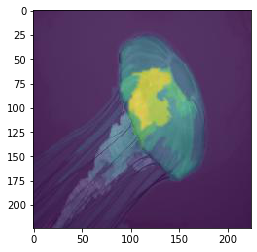

Predicted label: jellyfish


In [10]:
# Attributions contain an attribution per given example.
attributions[0].visualize_attributions()

# Get the label
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
print('Predicted label:', imagenet_labels[108])

### Explore Different Parameters
There are various parameters you can change. `step_count` in XRAI config, baselines, label indices are some of them. Use `params_override` in the `explain` call to change these parameters. Alternatively, you can create a new model instance with updated parameters. To reset other parameters such as [visualization](https://cloud.google.com/ai-platform/prediction/docs/ai-explanations/visualizing-explanations), you need to recreate the metadata while specifying a dictionary for the `visualization` argument in the `set_image_metadata` function.

Check out the [github repo](https://github.com/GoogleCloudPlatform/explainable_ai_sdk) for Explainable AI SDK for the API and parameters.

Explaining label: conch
Label Index 113
Example Score: 0.0043
Baseline Score: 0.0005
Approximation Error: 0.0130


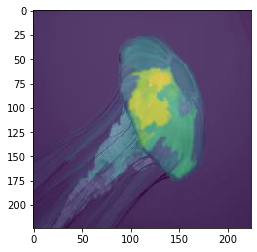

In [11]:
# Explain a different label (conch).
print('Explaining label:', imagenet_labels[113])
attributions = lm.explain([{'bytes_inputs': image_bytes}],
                          params=configs.AttributionParameters(label_indices=[113]))

# Visualize why the model might have thought the image was a conch.
attributions[0].visualize_attributions()

# [Optional] Deploy the Model to AI Platform
In this optional step, you will deploy the model to AI Platform to have a hosted solution to get model explanations.

In [12]:
PROJECT_ID = "your-project-id"  # Change to your project ID.

### Create the Model
**You only need to run this once.**

In [13]:
MODEL = 'imagenet'
!gcloud ai-platform models create $MODEL --enable-logging --regions=us-central1

Using endpoint [https://ml.googleapis.com/]
Created ml engine model [projects/caipe-dev/models/imagenet].


### Save the Model to GCS
You need to save the model to a GCS bucket to deploy to AI Platform.



#### Create a bucket
**You need to run this only once.**

Note that you can use an existing GCS bucket instead of running this gsutil command, which creates a new one.

In [14]:
BUCKET_NAME = PROJECT_ID + "_imagenet_model"  # Rename to your liking
REGION = "us-central1"

In [ ]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Call `save_model_with_metadata` function to save the model and the metadata to your bucket.

This time, you can set different visualization settings and observe the differences.

In [ ]:
md_builder.set_image_metadata('numpy_inputs', visualization={
    "type": "Pixels",  # Recommended for XRAI
    "polarity": "positive",
    "clip_below_percentile": 60,
    "clip_above_percentile": 100,
    "color_map": "viridis"
})

model_gcs_path = "gs://" + BUCKET_NAME + "/model"
md_builder.save_model_with_metadata(model_gcs_path)

### Create a Model Version.

In [18]:
# Each time you create a version the name should be unique
MODEL_VERSION = 'xrai_v1'

In [ ]:
# Create the version with gcloud
!gcloud beta ai-platform versions create $MODEL_VERSION \
--model $MODEL \
--origin $model_gcs_path \
--runtime-version 2.1 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method xrai \
--num-integral-steps 50

In [ ]:
# Make sure the XRAI model deployed correctly. State should be `READY` in the following log
!gcloud ai-platform versions describe $MODEL_VERSION --model $MODEL

**Make sure that the state of the model is `READY` before moving on.**

## Explain an Image with the Deployed Model
Now, call the deployed model using `explainable_ai_sdk` to get attributions for the same image. First, create a remote model instance through `explainable_ai_sdk` providing project, model, and version parameters. Then, you can call the `explain` function to receive the explanations from the deployed model the same way you would from a local model above.

*Note: Deployed models don't support parameter overriding. Hence if you provide `params` in the `explain` call, it won't have any effect in the explanations.*

In [21]:
# Create the model
rm = explainable_ai_sdk.load_model_from_ai_platform(PROJECT_ID, MODEL, MODEL_VERSION)

Encode the image bytes as a base64 string to be sent over.

In [22]:
b64str = b64encode(image_bytes).decode('utf-8')

attributions = rm.explain([{'bytes_inputs': {'b64': b64str}}])

Label Index 108
Example Score: 0.9676
Baseline Score: 0.0128
Approximation Error: 0.0123


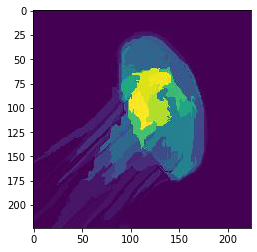

In [23]:
# Note the difference in visualization due to different visualization settings.
attributions[0].visualize_attributions()

# Cleaning up

*Run these steps only if you deployed a model to AI Platform. Otherwise, feel free to ignore.*

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.


In [ ]:
# Delete model version resource
# Note that if there are multiple model versions, you need to delete them
# one by one.
! gcloud ai-platform versions delete $MODEL_VERSION --quiet --model $MODEL

# Delete model resource
! gcloud ai-platform models delete $MODEL --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r gs://$BUCKET_NAME